In [963]:
%load_ext zipline
%load_ext watermark
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


# 1. Импортируем библиотеки

In [1256]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, order_value, order_target_value, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)
# комиссии
from zipline.finance import commission
from zipline.finance import slippage
from zipline.finance.slippage import SlippageModel

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, date

# aинансовые данные
from yahoofinancials import YahooFinancials

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
from matplotlib import mlab
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
%matplotlib inline

plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 200

#векторный формат
%config InlineBackend.figure_format = 'svg'

from tqdm import tqdm

# 2. Загрузка данных

In [965]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close', 'adjclose', 'volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    fig, ax = plt.subplots(figsize=[12, 4])
    
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date), color='green', fontsize=8);
    plt.yscale('log')

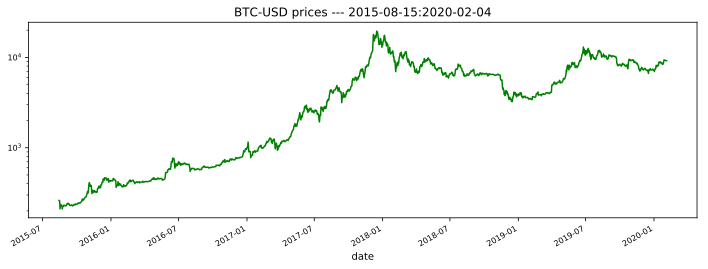

In [966]:
download_csv_data(ticker='BTC-USD', 
                  start_date='2015-08-15', 
                  end_date='2020-02-04', 
                  freq='daily', 
                  path='data/BTC.csv')

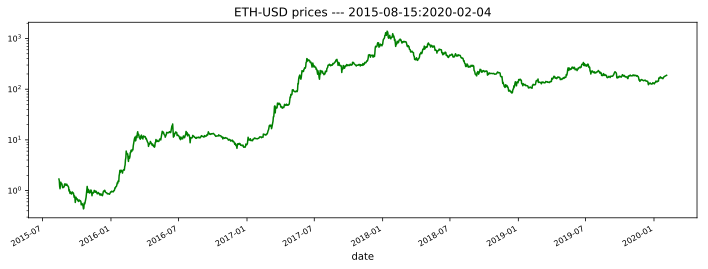

In [967]:
download_csv_data(ticker='ETH-USD', 
                  start_date='2015-08-15', 
                  end_date='2020-02-04', 
                  freq='daily', 
                  path='data/ETH.csv')

## Формируем данные для анализа стратегии

In [1300]:
# Список финансовых инструментов в портфеле
TIKERS = ['BTC', 'ETH']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose', 'volume']

In [1301]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    
    print(data[tiker].head())

COLUMNS = ['open', 'close', 'volume']

                  open       close      volume
date                                          
2015-08-05  278.576996  278.576996  18792100.0
2015-08-06  279.584991  279.584991  42484800.0
2015-08-07  260.997009  260.997009  58533000.0
2015-08-08  265.083008  265.083008  23789600.0
2015-08-09  264.470001  264.470001  20979400.0
                open     close     volume
date                                     
2015-08-06  2.772120  2.772120   164329.0
2015-08-07  0.753325  0.753325   674188.0
2015-08-08  0.701897  0.701897   532170.0
2015-08-09  0.708448  0.708448   405283.0
2015-08-10  1.067860  1.067860  1463100.0


## Приводим данные к одинаковой длинне

In [1302]:
for tiker in TIKERS:
    if tiker == 'BTC':
        continue
    else:
        tmp = data['BTC'].copy()
        for column in COLUMNS:
            tmp[column] = 0    

        # удаляем лишнее
        tmp = tmp.iloc[:(len(tmp)-len(data[tiker]))]

        # Вносим данные
        tmp = tmp.append(data[tiker], ignore_index = False)
        data[tiker] = tmp

In [1303]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 1646 (major_axis) x 3 (minor_axis)
Items axis: BTC to ETH
Major_axis axis: 2015-08-05 00:00:00+00:00 to 2020-02-05 00:00:00+00:00
Minor_axis axis: open to volume


## Определяем параметры и функции алгоритма

In [1319]:
# https://github.com/quantopian/zipline/issues/1844
# Custom slippage model
class InstantSlippage(SlippageModel):
    
    def process_order(self, data, order):
        # Use price from previous bar
        price = data.history(order.sid, 'price', 2, '1d')[0]
        
        # Alternative: Use current bar's open, instead of close
        # price = data.current(order.sid, 'open')

        return (price, order.amount)

In [1305]:
WEIGHTS = [[0.8, 0], [1.0, 0.0]]
ASSETS_START = [date(2015, 8, 15)]
ORDER_MAX = 100
COMMISSION = 0
CAPITAL_BASE = 10000

In [1306]:
ORDER_FINISHED_FLAG = []
START_BUY_DAY_FLAG = []
for i in range(len(panel)):
    ORDER_FINISHED_FLAG.append(False)
    START_BUY_DAY_FLAG.append(True)

In [1307]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    #context.set_slippage(slippage.FixedSlippage(spread=0.0))
    context.set_slippage(InstantSlippage())
    
    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]
    
    context.weights = WEIGHTS
    context.n_assets = len(context.assets)
    
    context.window = 1
    
    context.stage = 0
    
    context.assets_start = ASSETS_START
    
    context.order_max = ORDER_MAX
    
    context.order_finished_flag = ORDER_FINISHED_FLAG
    
    context.rebalance_period = 63
    context.time = 0
    
    context.start_buy_day_flag = START_BUY_DAY_FLAG
    
    context.cash = CAPITAL_BASE

In [1308]:
def asset_chek(context, day, n):
    
    # Проверка начала закупки
    if day == context.assets_start[n]:
        context.stage = n + 1
        context.time = 0
        
        # Обнуляем флаги сигнализируещие о завершении ордера 
        # логика в том, что когда подключается новый актив, веса других активов меняются, следовательно нужны ордеры
        for i, flag in enumerate(context.order_finished_flag):
            context.order_finished_flag[i] = False

In [1309]:
def start_buying_check(context, data):
    
    prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')
    day = prices.index[0].date()
    
    # проверяем каждый актив
    for i in range(0, context.n_assets -1):
        asset_chek(context, day, i)

In [1310]:
def orders(context, data):
    
    prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')
    
    #print(prices.index[0].date())
    
    # Вычисляем потенциальное изменение веса каждого актива
    for i, asset in enumerate(context.assets):
         
        #print('Входим в дневном цикле в актив', asset, context.order_finished_flag)    
            
        volume = data.current(asset, 'volume')
        price = data.current(asset, 'price')
            
        # Проверка на актив, заданный вес которого равен 0
        target_weight = context.weights[context.stage][i]
        #print('Целевой вес =', target_weight, asset)
        
        if target_weight == 0:
            context.order_finished_flag[i] = True
            #print('Изменение статуса актива', asset, context.order_finished_flag)
            continue
            
            
        # Проверяем стоит ли рассматривать данный актив или уже ордер был сделан
        if context.order_finished_flag[i] == False:
            
            if context.start_buy_day_flag[i] == True:
                current_weight = 0
                context.start_buy_day_flag[i] = False
            else: 
                current_weight = context.portfolio.current_portfolio_weights.get(key = asset)
            
            #print('Текущий вес актива =', current_weight, asset)


            # Продажа актива
            if current_weight > target_weight:
                    
                # Проверка ограничения по объему
                potential_weight_change = (volume*context.order_max)/context.portfolio.portfolio_value

                weight_change = current_weight - target_weight

                if potential_weight_change >= weight_change:

                    # Полностью реализуем целевой вес актиа
                    order_target_percent(asset, target_weight)
                    context.order_finished_flag[i] = True
                    #print(prices.index[0].date(), ' - Продажа завершена', asset)
                else:
                        
                    # Частично продаем приводя текущий вес ближе к целевому
                    available_weight = current_weight - potential_weight_change
                    order_target_percent(asset, available_weight)
                    #print(prices.index[0].date(), ' - Частичная продажа', asset)
                        
            # Покупка активов
            if current_weight < target_weight:
                    
                # Проверка ограничения по объему
                volume_potential_weight_change = (volume*context.order_max)/context.portfolio.portfolio_value
                    
                # Проверка ограничения по количеству наличных
                cash_potential_weight_change = context.portfolio.cash/context.portfolio.portfolio_value
                        
                # потенциальное изменение веса равна меньшуму из двух ограничений
                potential_weight_change = 0
                if volume_potential_weight_change > cash_potential_weight_change:
                    potential_weight_change = cash_potential_weight_change
                else:
                    potential_weight_change = volume_potential_weight_change
                    
                weight_change = target_weight - current_weight 

                if potential_weight_change >= weight_change:

                    # Полностью реализуем целевой вес актиа
                    order_target_percent(asset, target_weight)
                    context.order_finished_flag[i] = True
                    #print(prices.index[0].date(), ' - Закупка завершена',asset)

                else:
                    # Частично покупаем приводя текущий вес ближе к целевому
                    available_weight = current_weight + potential_weight_change
                    order_target_percent(asset, available_weight)
                    #print(prices.index[0].date(), ' - Частичная закупка', asset)
                
                
    # Считаем количество завершенных закупок
    verification = 0
    for i in context.order_finished_flag:
        if i == True:
            verification += 1
        
    # Если все закупка/ребаллансировка завершена, начинаем отсчет дней до ребаллансировки
    if verification == len(context.order_finished_flag):
        context.time += 1
        #print(prices.index[0].date(), ' - Закупка/ребаллансировка портфеля закончена')
            
        # Обнуляем флаги сигнализируещие о завершении ордера
        for i, flag in enumerate(context.order_finished_flag):
            context.order_finished_flag[i] = False

In [1311]:
def handle_data(context, data):
    
    prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')
    day = prices.index[0].date()
    #print(day)
    
    # Проверка начала закупки акивов (меняем веса активов и обнуляем context.time)   DONE
    start_buying_check(context, data)    
    
    
    # Когда context.time = 0 - закупка, когда context.time кратно периоду ребаллансировки - ребаллансировка
    if context.time == 0 or (context.time % context.rebalance_period == 0):     
    
        orders(context, data)
    
    else:
        context.time += 1

In [1312]:
perf = zipline.run_algorithm(start=datetime(2015, 8, 15, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2020, 2, 4, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              #trading_calendar=AlwaysOpenCalendar(),
                              capital_base=CAPITAL_BASE,
                              handle_data=handle_data,
                              data=panel)

In [1313]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

In [1314]:
#qf.get_performance_summary(returns)

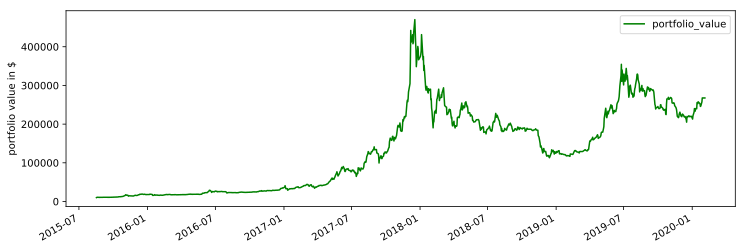

In [1315]:
fig, ax = plt.subplots(figsize=[12, 4])

# portfolio value
perf.portfolio_value.plot(color='g')
ax.set_ylabel('portfolio value in $')
ax.tick_params(axis = 'x', direction = 'out')

plt.legend()
plt.show()

#print('Final portfolio value (including cash): {}$'.format(np.round(perf.portfolio_value[-1], 2)))

In [1316]:
#Поправляем индексацию
new_index = pd.Series(pd.to_datetime(positions.index).date).map(lambda x: x.strftime('%Y-%m-%d'))
weights_df = pd.DataFrame.from_records(positions, index=new_index)
weights_df.head()

,Equity(0 [BTC]),cash
2015-08-18,8387.308212,2190.077
2015-08-19,8707.950226,2190.077
2015-08-20,8605.053009,2190.077
2015-08-21,8524.429977,2190.077
2015-08-24,8199.532761,2190.077


In [1317]:
# Поправляем названия столбцов
#weights_df.columns = ['BTC', 'ETH', 'Cash']
weights_df.columns = ['BTC', 'Cash']

# Нормирование весов в файле
norm_weights_df = weights_df.copy()
#norm_weights_df['BTC'] = weights_df['BTC']/(weights_df['ETH'] + weights_df['BTC'] + weights_df['Cash'])    
#norm_weights_df['ETH'] = weights_df['ETH']/(weights_df['ETH'] + weights_df['BTC'] + weights_df['Cash'])
#norm_weights_df['Cash'] = weights_df['Cash']/(weights_df['ETH'] + weights_df['BTC'] + weights_df['Cash'])
                                              
norm_weights_df['BTC'] = weights_df['BTC']/(weights_df['BTC'] + weights_df['Cash'])
norm_weights_df['Cash'] = weights_df['Cash']/(weights_df['BTC'] + weights_df['Cash'])
    
# convert date objects from pandas format to python datetime
norm_weights_df.index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in norm_weights_df.index]
                                              
norm_weights_df.head()

,BTC,Cash
2015-08-18,0.792947,0.207053
2015-08-19,0.799039,0.200961
2015-08-20,0.797124,0.202876
2015-08-21,0.795597,0.204403
2015-08-24,0.789205,0.210795


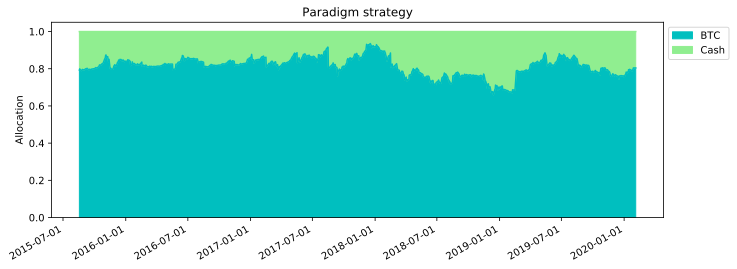

In [1318]:
plt.rcParams['figure.figsize'] = [11, 4]

#norm_weights_df = norm_weights_df[['ETH', 'BTC', 'Cash']]
norm_weights_df = norm_weights_df[['BTC', 'Cash']]
# plot the results
col = ['c', 'lightgreen', 'seagreen']
ax = norm_weights_df.plot(kind='area', stacked=True, color = col) # stacked=True показывает веса в одном столбце

# set monthly locator

##### Градуировка https://matplotlib.org/3.1.0/gallery/ticks_and_spines/tick-locators.html
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

ax.tick_params(axis = 'both', direction = 'out')
ax.set(title = 'Paradigm strategy', ylabel='Allocation')
ax.legend(bbox_to_anchor=(1,1))
plt.show()